In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load CSV file
data = pd.read_csv("nbastats.csv")
data

,Player,Age,Team,Pos,G,GS,MP,PER,TS%,3PAr,...,VORP,Awards,Year,AS,ANBA,DPOY,RPOY,SPOY,MIP,MVP
0,James Harden,25,HOU,SG,81,81,2981,26.7,0.605,0.378,...,8.1,MVP-2ASNBA1,2015,1,1,0,0,0,0,0
1,Andrew Wiggins,19,MIN,SF,82,82,2969,13.9,0.517,0.111,...,-0.3,ROY-1,2015,0,0,0,1,0,0,0
2,Trevor Ariza,29,HOU,SF,82,82,2930,12.7,0.539,0.610,...,2.2,DPOY-13,2015,0,0,0,0,0,0,0
3,Damian Lillard,24,POR,PG,82,82,2925,20.7,0.560,0.421,...,4.9,AS,2015,1,0,0,0,0,0,0
4,Chris Paul,29,LAC,PG,82,82,2857,26.0,0.596,0.298,...,7.2,MVP-6DPOY-15ASNBA2,2015,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6773,Malcolm Cazalon,22,DET,SG,1,0,3,0.0,NaN,NaN,...,0.0,NaN,2024,0,0,0,0,0,0,0
6774,Jalen Crutcher,24,NOP,PG,1,0,3,-12.6,0.000,0.000,...,0.0,NaN,2024,0,0,0,0,0,0,0
6775,Dmytro Skapintsev,25,NYK,C,2,0,2,-19.3,0.000,0.000,...,0.0,NaN,2024,0,0,0,0,0,0,0
6776,Justin Jackson,28,MIN,SF,2,0,1,0.0,NaN,NaN,...,0.0,NaN,2024,0,0,0,0,0,0,0


In [2]:
# Group player that was in multiple in a year to TOT
team_counts = data.groupby(["Player", "Year"])["Team"].transform("nunique")
data.loc[team_counts > 1, "Team"] = "TOT"

def keep_first_tot(group):
    if (group["Team"] == "TOT").any():
        tot_rows = group[group["Team"] == "TOT"]
        first_tot_index = tot_rows.index.min()
        return group.loc[[first_tot_index]]
    else:
        return group
    
data = (
    data.groupby(["Player", "Year"], group_keys=False)
      .apply(keep_first_tot)
      .reset_index(drop=True)
)

In [3]:
# Make sure Data range is 2015 - 2022
data = data[(data['Year'] >= 2015) & (data['Year'] <= 2022)]
data.sort_values(by=["Year", "Player"], inplace=True)
data.reset_index(drop=True, inplace=True)
data

,Player,Age,Team,Pos,G,GS,MP,PER,TS%,3PAr,...,VORP,Awards,Year,AS,ANBA,DPOY,RPOY,SPOY,MIP,MVP
0,A.J. Price,28,TOT,PG,26,0,324,12.0,0.451,0.416,...,0.0,NaN,2015,0,0,0,0,0,0,0
1,Aaron Brooks,30,CHI,PG,82,21,1885,14.4,0.534,0.383,...,0.5,6MOY-11,2015,0,0,0,0,0,0,0
2,Aaron Gordon,19,ORL,PF,47,8,797,11.4,0.517,0.231,...,-0.2,NaN,2015,0,0,0,0,0,0,0
3,Adreian Payne,23,TOT,PF,32,22,739,7.7,0.443,0.041,...,-0.9,NaN,2015,0,0,0,0,0,0,0
4,Al Horford,28,ATL,C,76,76,2318,21.4,0.563,0.037,...,3.6,AS,2015,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4193,Zach LaVine,26,CHI,SG,67,67,2328,20.0,0.605,0.401,...,2.6,AS,2022,1,0,0,0,0,0,0
4194,Zavier Simpson,24,OKC,PG,4,4,174,7.7,0.406,0.154,...,-0.3,NaN,2022,0,0,0,0,0,0,0
4195,Zeke Nnaji,21,DEN,PF,41,1,698,13.5,0.629,0.430,...,0.0,NaN,2022,0,0,0,0,0,0,0
4196,Ziaire Williams,20,MEM,SF,62,31,1346,9.7,0.559,0.571,...,-0.3,NaN,2022,0,0,0,0,0,0,0


In [4]:
# Uncleaned AS data
Davis_df = data[data["Player"].str.contains("Anthony Davis", case=False, na=False)]
Davis_df

,Player,Age,Team,Pos,G,GS,MP,PER,TS%,3PAr,...,VORP,Awards,Year,AS,ANBA,DPOY,RPOY,SPOY,MIP,MVP
29,Anthony Davis,21,NOP,PF,68,68,2455,30.8,0.591,0.010,...,6.7,MVP-5DPOY-4ASNBA1,2015,1,1,0,0,0,0,0
521,Anthony Davis,22,NOP,C,61,61,2164,25.0,0.559,0.095,...,3.2,DPOY-9AS,2016,1,0,0,0,0,0,0
995,Anthony Davis,23,NOP,C,75,75,2708,27.5,0.580,0.088,...,5.4,MVP-9ASNBA1,2017,1,1,0,0,0,0,0
1482,Anthony Davis,24,NOP,PF,75,75,2727,28.9,0.612,0.111,...,5.9,MVP-3DPOY-3ASNBA1,2018,1,1,0,0,0,0,0
2018,Anthony Davis,25,NOP,C,56,56,1850,30.3,0.597,0.141,...,5.3,AS,2019,1,0,0,0,0,0,0
2547,Anthony Davis,26,LAL,PF,62,62,2131,27.4,0.610,0.199,...,5.4,MVP-6DPOY-2ASNBA1,2020,1,1,0,0,0,0,0
3075,Anthony Davis,27,LAL,PF,36,36,1162,22.1,0.556,0.163,...,2.0,AS,2021,1,0,0,0,0,0,0
3616,Anthony Davis,28,LAL,C,40,40,1404,23.9,0.578,0.101,...,2.0,NaN,2022,0,0,0,0,0,0,0


In [5]:
as_data = data
year = as_data["Year"]
name = as_data["Player"]
asd = as_data["AS"]

#To compare old uncleaned AS
as_data2 = pd.DataFrame({'Player':name, 'Year':year, 'AS':asd})
as_data2

,Player,Year,AS
0,A.J. Price,2015,0
1,Aaron Brooks,2015,0
2,Aaron Gordon,2015,0
3,Adreian Payne,2015,0
4,Al Horford,2015,1
...,...,...,...
4193,Zach LaVine,2022,1
4194,Zavier Simpson,2022,0
4195,Zeke Nnaji,2022,0
4196,Ziaire Williams,2022,0


In [6]:
df_as = pd.read_csv("as_data.csv")

# merge data by player & year
data = pd.merge(
    data.drop(columns=["AS"], errors="ignore"),
    df_as[["Player", "Year", "AS"]],
    on=["Player", "Year"],
    how="left"
)

# cleaned data
data.to_csv("data2.csv")
data

,Player,Age,Team,Pos,G,GS,MP,PER,TS%,3PAr,...,VORP,Awards,Year,ANBA,DPOY,RPOY,SPOY,MIP,MVP,AS
0,A.J. Price,28,TOT,PG,26,0,324,12.0,0.451,0.416,...,0.0,NaN,2015,0,0,0,0,0,0,0.0
1,Aaron Brooks,30,CHI,PG,82,21,1885,14.4,0.534,0.383,...,0.5,6MOY-11,2015,0,0,0,0,0,0,0.0
2,Aaron Gordon,19,ORL,PF,47,8,797,11.4,0.517,0.231,...,-0.2,NaN,2015,0,0,0,0,0,0,0.0
3,Adreian Payne,23,TOT,PF,32,22,739,7.7,0.443,0.041,...,-0.9,NaN,2015,0,0,0,0,0,0,0.0
4,Al Horford,28,ATL,C,76,76,2318,21.4,0.563,0.037,...,3.6,AS,2015,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4193,Zach LaVine,26,CHI,SG,67,67,2328,20.0,0.605,0.401,...,2.6,AS,2022,0,0,0,0,0,0,0.0
4194,Zavier Simpson,24,OKC,PG,4,4,174,7.7,0.406,0.154,...,-0.3,NaN,2022,0,0,0,0,0,0,0.0
4195,Zeke Nnaji,21,DEN,PF,41,1,698,13.5,0.629,0.430,...,0.0,NaN,2022,0,0,0,0,0,0,0.0
4196,Ziaire Williams,20,MEM,SF,62,31,1346,9.7,0.559,0.571,...,-0.3,NaN,2022,0,0,0,0,0,0,0.0


In [7]:
# check if AS is properly in
Payne_df = data[data["Player"].str.contains("Anthony Davis", case=False, na=False)]
Payne_df

,Player,Age,Team,Pos,G,GS,MP,PER,TS%,3PAr,...,VORP,Awards,Year,ANBA,DPOY,RPOY,SPOY,MIP,MVP,AS
29,Anthony Davis,21,NOP,PF,68,68,2455,30.8,0.591,0.010,...,6.7,MVP-5DPOY-4ASNBA1,2015,1,0,0,0,0,0,0.156
521,Anthony Davis,22,NOP,C,61,61,2164,25.0,0.559,0.095,...,3.2,DPOY-9AS,2016,0,0,0,0,0,0,0.000
995,Anthony Davis,23,NOP,C,75,75,2708,27.5,0.580,0.088,...,5.4,MVP-9ASNBA1,2017,1,0,0,0,0,0,0.002
1482,Anthony Davis,24,NOP,PF,75,75,2727,28.9,0.612,0.111,...,5.9,MVP-3DPOY-3ASNBA1,2018,1,0,0,0,0,0,0.441
2018,Anthony Davis,25,NOP,C,56,56,1850,30.3,0.597,0.141,...,5.3,AS,2019,0,0,0,0,0,0,0.000
2547,Anthony Davis,26,LAL,PF,62,62,2131,27.4,0.610,0.199,...,5.4,MVP-6DPOY-2ASNBA1,2020,1,0,0,0,0,0,0.081
3075,Anthony Davis,27,LAL,PF,36,36,1162,22.1,0.556,0.163,...,2.0,AS,2021,0,0,0,0,0,0,0.000
3616,Anthony Davis,28,LAL,C,40,40,1404,23.9,0.578,0.101,...,2.0,NaN,2022,0,0,0,0,0,0,0.000


In [8]:
# Detect Missing Values
missing_values = data.isnull().sum()
missing_values

Player       0
Age          0
Team         0
Pos          0
G            0
GS           0
MP           0
PER          0
TS%         22
3PAr        23
FTr         23
ORB%         0
DRB%         0
TRB%         0
AST%         0
STL%         0
BLK%         0
TOV%        20
USG%         0
OWS          0
DWS          0
WS           0
WS/48        0
OBPM         0
DBPM         0
BPM          0
VORP         0
Awards    3752
Year         0
ANBA         0
DPOY         0
RPOY         0
SPOY         0
MIP          0
MVP          0
AS          10
dtype: int64

In [9]:
# Clean NA
columns_to_fill = ['TS%','3PAr', 'FTr','TOV%']
data[columns_to_fill] = data[columns_to_fill].fillna(0) 
missing_values = data.isnull().sum()
data.dropna(how='any', inplace=True)
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 36 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  446 non-null    object 
 1   Age     446 non-null    int64  
 2   Team    446 non-null    object 
 3   Pos     446 non-null    object 
 4   G       446 non-null    int64  
 5   GS      446 non-null    int64  
 6   MP      446 non-null    int64  
 7   PER     446 non-null    float64
 8   TS%     446 non-null    float64
 9   3PAr    446 non-null    float64
 10  FTr     446 non-null    float64
 11  ORB%    446 non-null    float64
 12  DRB%    446 non-null    float64
 13  TRB%    446 non-null    float64
 14  AST%    446 non-null    float64
 15  STL%    446 non-null    float64
 16  BLK%    446 non-null    float64
 17  TOV%    446 non-null    float64
 18  USG%    446 non-null    float64
 19  OWS     446 non-null    float64
 20  DWS     446 non-null    float64
 21  WS      446 non-null    float64
 22  WS

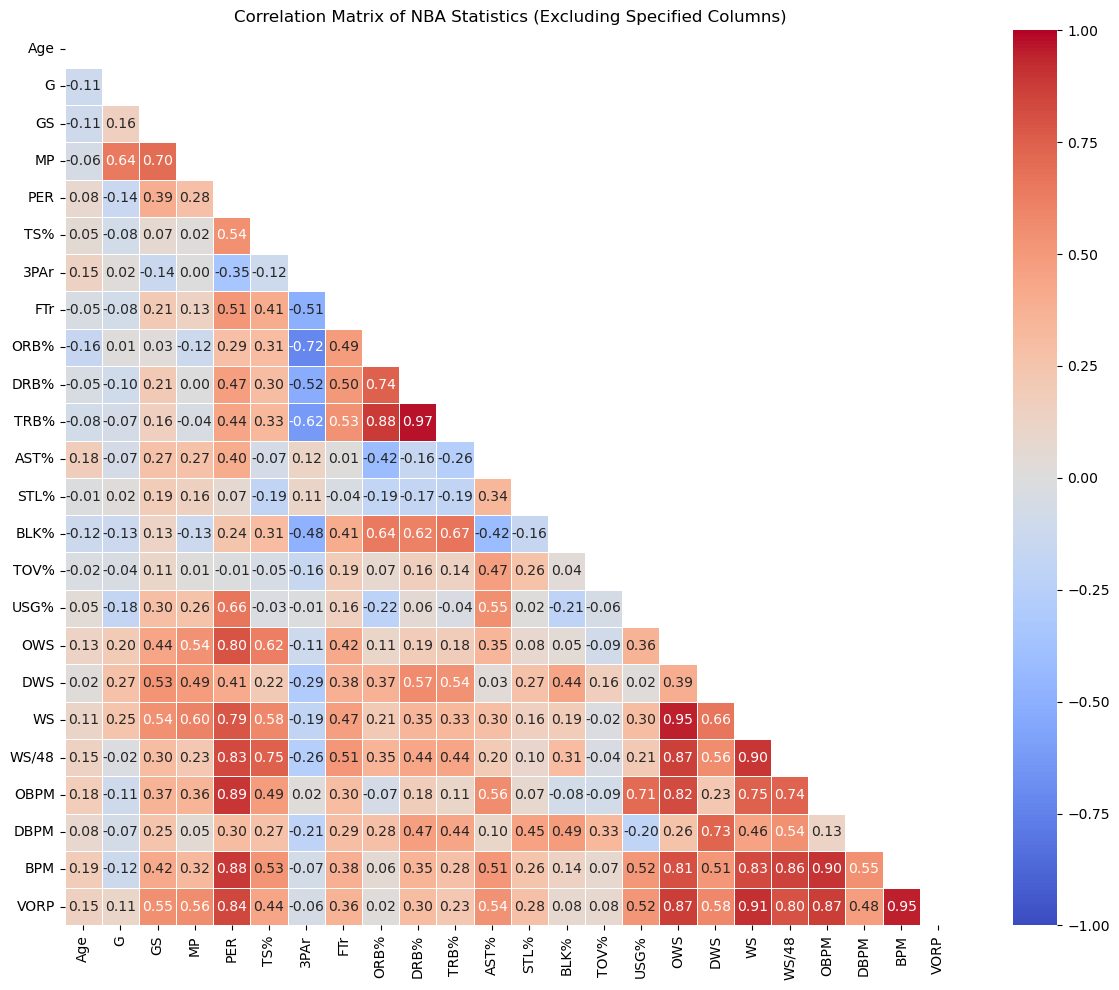

In [10]:
excluded_columns = ['Awards', 'Year', 'AS', 'ANBA', 'DPOY', 'RPOY', 'SPOY', 'MIP', 'MVP', 'Player', 'Team', 'Pos']

numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
included_columns = [col for col in numeric_columns if col not in excluded_columns]

# Make sure we have columns to correlate
if len(included_columns) < 2:
    print("Not enough numeric columns for correlation outside the excluded list")
else:
    # Calculate correlation matrix
    corr_matrix = data[included_columns].corr()
    
    # Create the correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Optional: mask upper triangle
    
    # Create heatmap
    sns.heatmap(
        corr_matrix, 
        mask=mask,  # Comment this line if you want to see the full matrix
        annot=True, 
        cmap='coolwarm', 
        fmt=".2f", 
        linewidths=0.5,
        vmin=-1, 
        vmax=1
    )
    
    plt.title('Correlation Matrix of NBA Statistics (Excluding Specified Columns)')
    plt.tight_layout()
    plt.savefig("nba_correlation_matrix.png", dpi=300)  # Adjust dpi for image quality
    plt.show()

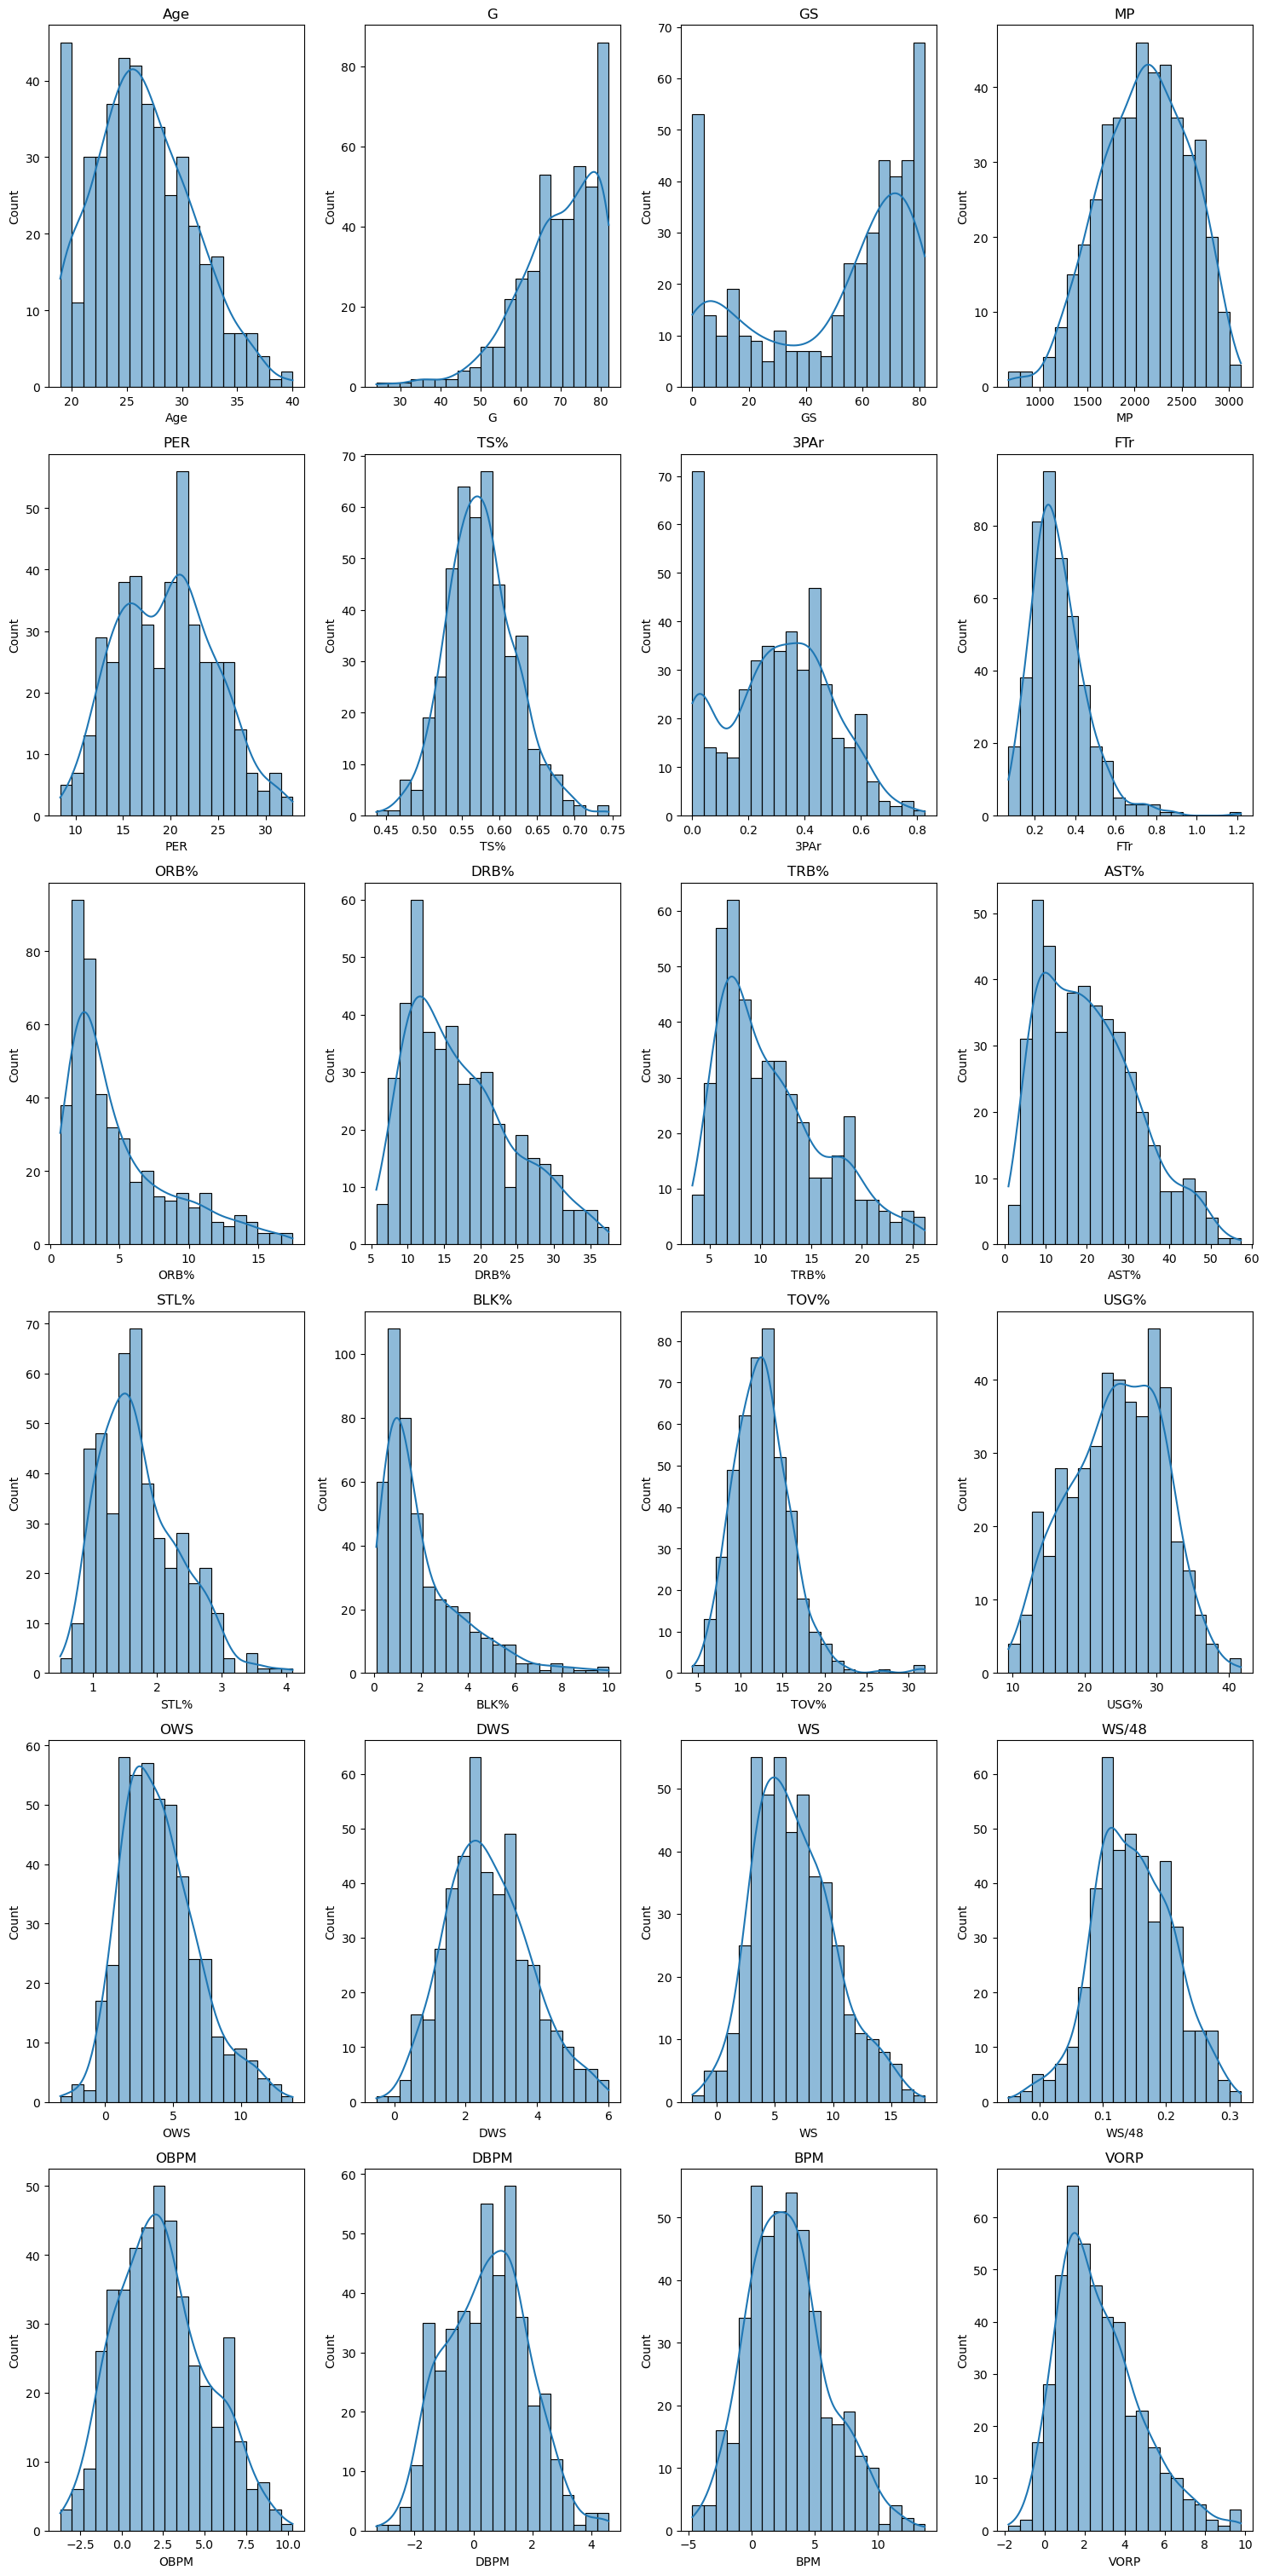

In [11]:
exclude_cols = ['Awards', 'Year', 'AS', 'ANBA', 'DPOY', 'RPOY', 'SPOY', 'MIP', 'MVP', 'Player', 'Team', 'Pos']

# Select only numerical columns excluding the specified ones
numeric_cols = data.select_dtypes(include=['number']).drop(columns=exclude_cols, errors='ignore')

# Create a matrix of histograms
fig, axes = plt.subplots(nrows=len(numeric_cols.columns) // 3 + 1, ncols=4, figsize=(15, 5 * (len(numeric_cols.columns) // 3 + 1)))

# Flatten axes array in case we have a different number of histograms
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(numeric_cols.columns):
    sns.histplot(data[col], ax=axes[i], kde=True, bins=20)
    axes[i].set_title(col)

# Remove empty subplots if the number of columns is not a multiple of 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("nba_histograms.png", dpi=600)  # Adjust dpi for image quality
plt.show()


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier

# Load Data
df = pd.read_csv("data2.csv")

# Clean NA
columns_to_fill = ['TS%','3PAr', 'FTr','TOV%']
df[columns_to_fill] = df[columns_to_fill].fillna(0) 
missing_values = df.isnull().sum()
df.dropna(how='any', inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

# predict data for later
predict_data = df[df['Year'] == 2022].copy()
predict_data.drop(columns=['Awards'], inplace = True)
predict_data.to_csv('predict_data_2022.csv', index=False)

# Drop non-predictor columns
df = df.drop(columns=["Year", "Player", "Awards", "Team", "Pos"], errors='ignore')

# Define features and targets
X = df.drop(columns=["AS"])
y = df[["AS"]]

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 37 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  446 non-null    int64  
 1   Player      446 non-null    object 
 2   Age         446 non-null    int64  
 3   Team        446 non-null    object 
 4   Pos         446 non-null    object 
 5   G           446 non-null    int64  
 6   GS          446 non-null    int64  
 7   MP          446 non-null    int64  
 8   PER         446 non-null    float64
 9   TS%         446 non-null    float64
 10  3PAr        446 non-null    float64
 11  FTr         446 non-null    float64
 12  ORB%        446 non-null    float64
 13  DRB%        446 non-null    float64
 14  TRB%        446 non-null    float64
 15  AST%        446 non-null    float64
 16  STL%        446 non-null    float64
 17  BLK%        446 non-null    float64
 18  TOV%        446 non-null    float64
 19  USG%        446 non-null    f

C:\Users\User\AppData\Local\Temp\ipykernel_33556\1562389434.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


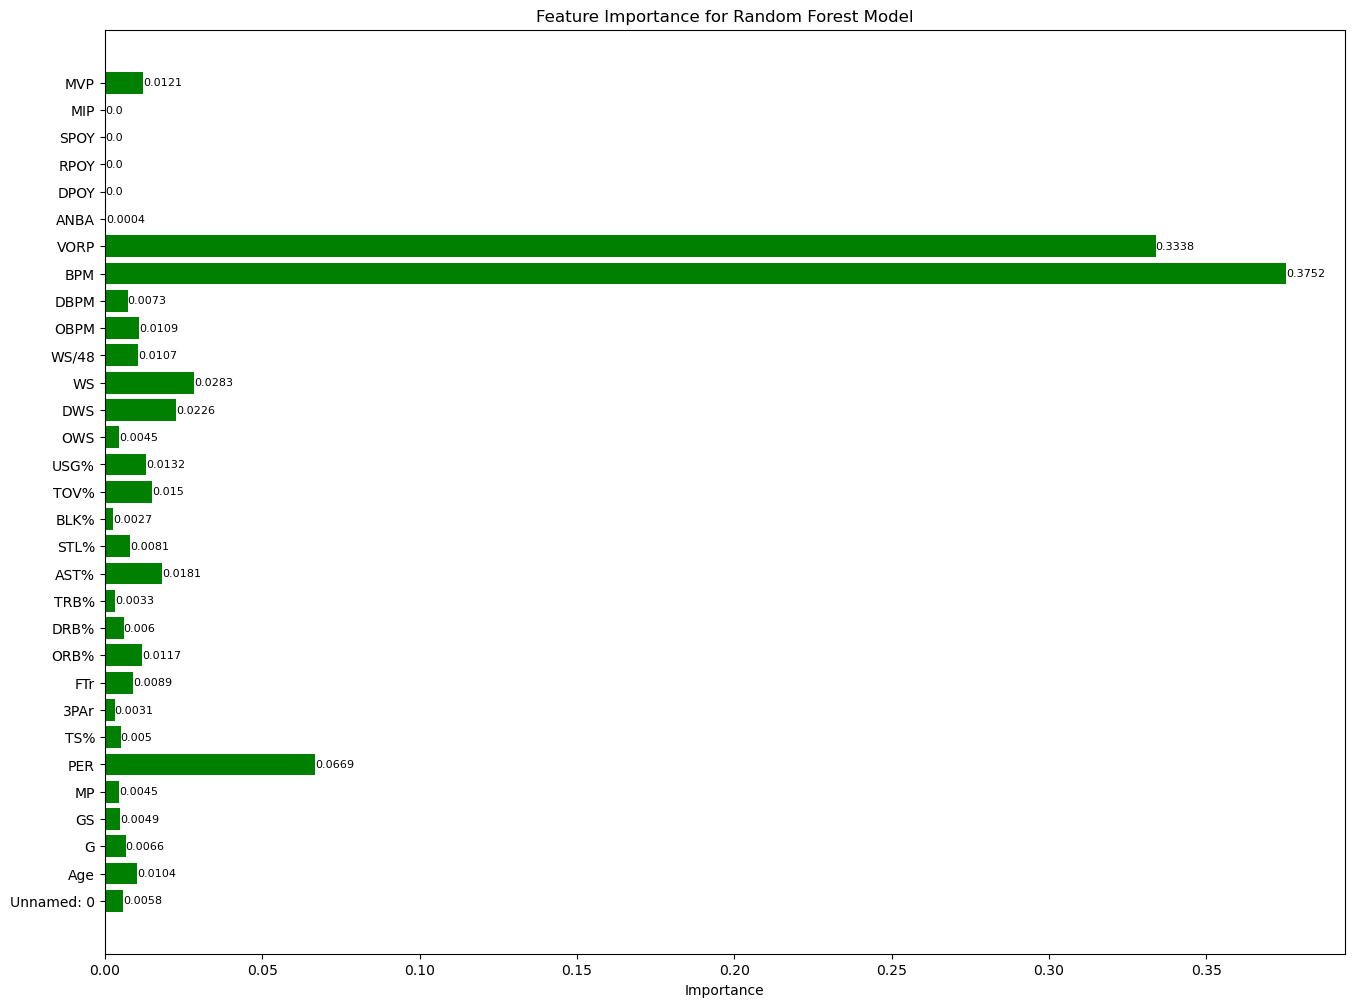

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Train the best model
model = RandomForestRegressor(random_state=138, max_depth=60, 
                            min_samples_leaf=2, min_samples_split=2, n_estimators=600, n_jobs= -1)

model.fit(X_train, y_train)

feature_importance = model.feature_importances_

# Feature importance visualization
fig, ax = plt.subplots(figsize=(16, 12))
bars = ax.barh(range(len(feature_importance)), feature_importance, color='green')
ax.set_title('Feature Importance for Random Forest Model')
ax.set_yticks(range(len(X.columns)))
ax.set_yticklabels(X.columns)
ax.set_xlabel('Importance')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, round(bar.get_width(), 4),
             va='center', ha='left', color='black', fontsize=8)
plt.show()

In [14]:
selected_features = X.columns[feature_importance > 0.01]
selected_features_df = X[selected_features]
selected_features_df.columns

Index(['Age', 'PER', 'ORB%', 'AST%', 'TOV%', 'USG%', 'DWS', 'WS', 'WS/48',
       'OBPM', 'BPM', 'VORP', 'MVP'],
      dtype='object')

Linear Regression Metrics:
  Mean Squared Error (MSE): 0.0091
  R-squared (R2): 0.7708
  Mean Absolute Error (MAE): 0.0562


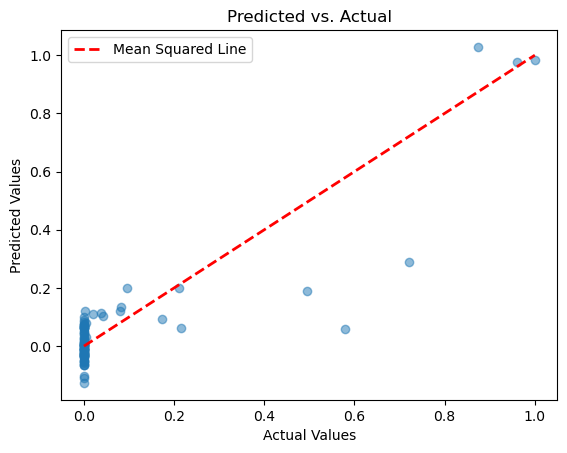

Ridge Regression Metrics:
  Mean Squared Error (MSE): 0.0091
  R-squared (R2): 0.7719
  Mean Absolute Error (MAE): 0.0555


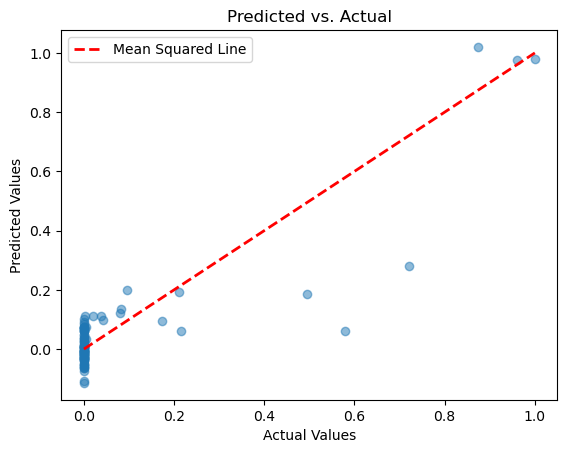

Lasso Regression Metrics:
  Mean Squared Error (MSE): 0.0402
  R-squared (R2): -0.0096
  Mean Absolute Error (MAE): 0.0910


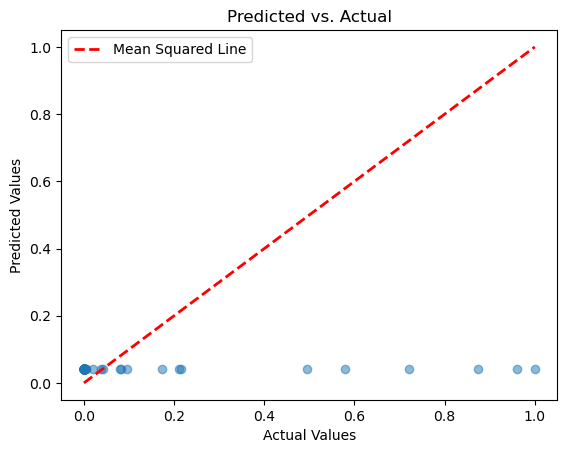

Decision Tree Metrics:
  Mean Squared Error (MSE): 0.0120
  R-squared (R2): 0.6990
  Mean Absolute Error (MAE): 0.0346


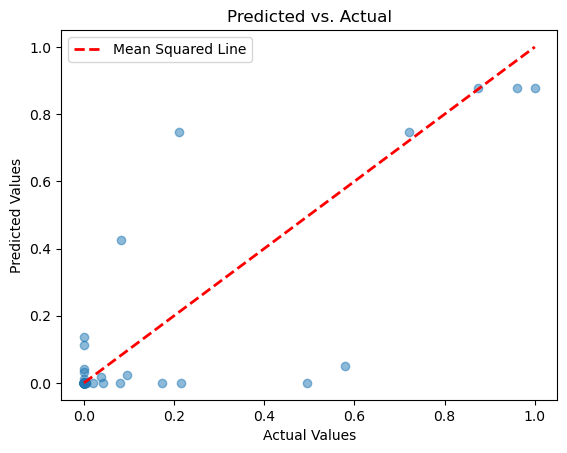

Random Forest Metrics:
  Mean Squared Error (MSE): 0.0070
  R-squared (R2): 0.8255
  Mean Absolute Error (MAE): 0.0300


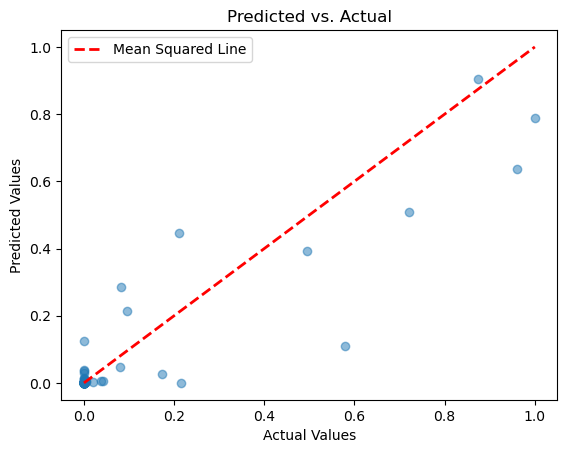

Gradient Boosting Metrics:
  Mean Squared Error (MSE): 0.0059
  R-squared (R2): 0.8510
  Mean Absolute Error (MAE): 0.0264


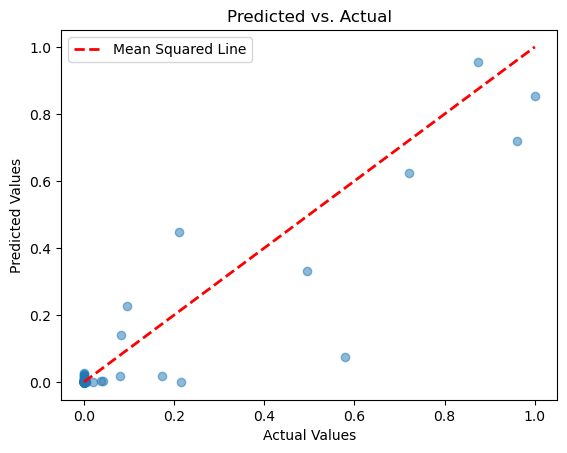

Polynomial Regression Metrics:
  Mean Squared Error (MSE): 0.0156
  R-squared (R2): 0.6098
  Mean Absolute Error (MAE): 0.0719


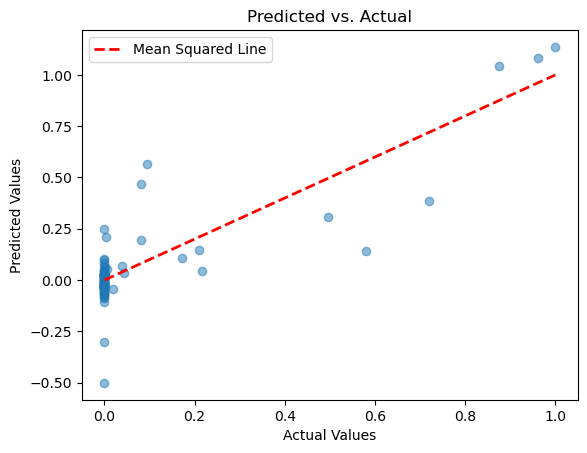

In [21]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

#Load X & y
X = selected_features_df
y = df['AS']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Set Model
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    ('Polynomial Regression', make_pipeline(PolynomialFeatures(degree=2), LinearRegression()))
]

# Model for Loop
pipelines = []

for model_name, model in models:
    pipelines.append((
        model_name,
        Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    ))

for model_name, model in pipelines:
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{model_name} Metrics:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  R-squared (R2): {r2:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    
    # Predicted vs Actual Data
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Mean Squared Line')
    plt.title('Predicted vs. Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

In [16]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

# Define a parameter grid to search over.
param_grid = {
    'model__n_estimators': [100, 200, 300, 320],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train.values.ravel())

# Print best hyperparameters and best score from the grid search
print("Best Parameters:")
print(grid_search.best_params_)
print(f"Best CV R² Score: {grid_search.best_score_:.4f}")

# Optionally, evaluate on the test set
y_pred = grid_search.predict(X_test)
print(f"Test R² Score: {r2_score(y_test, y_pred):.4f}")

Best Parameters:
{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best CV R² Score: 0.7384
Test R² Score: 0.8637


MSE: 0.0066, R^2: 0.8334, MAE: 0.0288


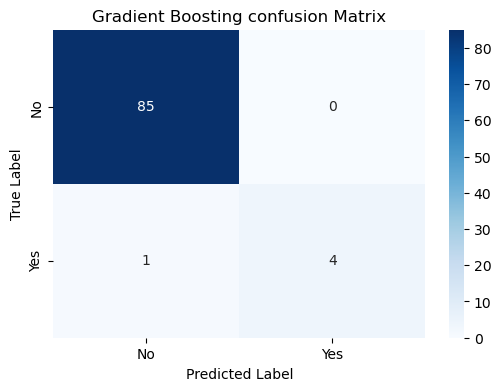

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        85
           1       1.00      0.80      0.89         5

    accuracy                           0.99        90
   macro avg       0.99      0.90      0.94        90
weighted avg       0.99      0.99      0.99        90



In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report

# Fit a regression model
model = RandomForestRegressor(
    random_state=42, criterion="absolute_error", max_features="sqrt", n_estimators=200, max_depth=None, bootstrap=True, 
    min_samples_split=2, min_samples_leaf=1
)
model.fit(X_train, y_train.values.ravel()) 
y_pred = model.predict(X_test)

# Evaluate with regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MSE: {mse:.4f}, R^2: {r2:.4f}, MAE: {mae:.4f}")

# Binarize the continuous predictions using a threshold
threshold = 0.5 
y_test_bin = (y_test >= threshold).astype(int)
y_pred_bin = (y_pred >= threshold).astype(int)

# Now compute and plot the confusion matrix
cm = confusion_matrix(y_test_bin, y_pred_bin)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Gradient Boosting confusion Matrix")
plt.show()

print(classification_report(y_test_bin, y_pred_bin))

In [18]:
predict_data.reset_index(drop=True, inplace=True)
predict_data

,Unnamed: 0,Player,Age,Team,Pos,G,GS,MP,PER,TS%,...,BPM,VORP,Year,ANBA,DPOY,RPOY,SPOY,MIP,MVP,AS
0,3602,Al Horford,35,BOS,C,69,69,2005,16.7,0.574,...,4.3,3.2,2022,0,0,0,0,0,0,0.000
1,3614,Andrew Wiggins,26,GSW,SF,73,73,2330,15.0,0.560,...,0.4,1.4,2022,0,0,0,0,0,0,0.000
2,3627,Bam Adebayo,24,MIA,C,56,56,1825,21.8,0.608,...,3.8,2.7,2022,0,0,0,0,0,0,0.000
3,3633,Bogdan Bogdanović,29,ATL,SG,63,27,1848,15.4,0.562,...,1.3,1.5,2022,0,0,0,0,0,0,0.000
4,3640,Brandon Clarke,25,MEM,PF,64,1,1246,23.7,0.660,...,4.2,2.0,2022,0,0,0,0,0,0,0.000
5,3655,Cade Cunningham,20,DET,SG,64,64,2088,13.1,0.504,...,-1.6,0.2,2022,0,0,0,0,0,0,0.000
6,3659,Cameron Johnson,25,PHO,PF,66,16,1730,15.2,0.625,...,2.7,2.1,2022,0,0,0,0,0,0,0.000
7,3680,Chris Paul,36,PHO,PG,65,65,2139,20.8,0.581,...,5.4,4.0,2022,1,0,0,0,0,0,0.002
8,3711,Darius Garland,22,CLE,PG,68,68,2430,19.0,0.576,...,2.6,2.8,2022,0,0,0,0,0,0,0.000
9,3721,De'Anthony Melton,23,MEM,SG,73,15,1657,15.2,0.529,...,1.9,1.6,2022,0,0,0,0,0,0,0.000


In [19]:
## see the index and share value
max_share = -1
max_share_index = -1

X_2022 = predict_data[selected_features]
y_2022_pred = model.predict(X_2022)

# prediction
for index, pred in enumerate(y_2022_pred):
    print(f"Player at index {index}, Predicted Award Share: {pred:.5f}")

    # Updating max_share and max_share_index if the current prediction is higher
    if pred > max_share:
        max_share = pred
        max_share_index = index

# Printing the player with the highest predicted award_share
print(f"\nThe player with the highest predicted award_share is at index {max_share_index}, with a value of {max_share:.5f}")

Player at index 0, Predicted Award Share: 0.0023
Player at index 1, Predicted Award Share: 0.0001
Player at index 2, Predicted Award Share: 0.0005
Player at index 3, Predicted Award Share: 0.0000
Player at index 4, Predicted Award Share: 0.0028
Player at index 5, Predicted Award Share: 0.0000
Player at index 6, Predicted Award Share: 0.0000
Player at index 7, Predicted Award Share: 0.0243
Player at index 8, Predicted Award Share: 0.0015
Player at index 9, Predicted Award Share: 0.0002
Player at index 10, Predicted Award Share: 0.0064
Player at index 11, Predicted Award Share: 0.0027
Player at index 12, Predicted Award Share: 0.0082
Player at index 13, Predicted Award Share: 0.0069
Player at index 14, Predicted Award Share: 0.0001
Player at index 15, Predicted Award Share: 0.0001
Player at index 16, Predicted Award Share: 0.0000
Player at index 17, Predicted Award Share: 0.0004
Player at index 18, Predicted Award Share: 0.6116
Player at index 19, Predicted Award Share: 0.0000
Player at 

In [20]:
# index 45 is Nikola Jokic, who is mvp winner od 2023